In [1]:
import pickle
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import load_model


# enabling utils' directory files to be imported
import sys
sys.path.append('../')

from utils import DataGenerator, config, visualization
from model import GAN

## Evaluating GANs

### No transfer learning model

In [2]:
n_generated_img = 4
images_dir = os.path.join(config.DATASET_DIR, "images") # data loaded for testing discriminator on real images

In [24]:
discriminator_path = "./trained_model/transfer_resnet/eight_epochs_dis.h5"
generator_path = "./trained_model/transfer_resnet/eigth_epochs_gen.h5"
learning_path = "./trained_model/from_scratch/training-history-first-gan.pkl"

In [25]:
gen = load_model(generator_path, compile=False)
dis = load_model(discriminator_path, compile=False)

In [17]:
with open(learning_path, 'rb') as file:
    history = pickle.load(file)

In [26]:
generated_images = gen.predict(tf.random.uniform((n_generated_img, config.NOISE_VECTOR_SIZE, 1)))

1/1 [==============================] - 0s 248ms/step


In [27]:
predictions = dis.predict(generated_images)

1/1 [==============================] - 1s 848ms/step


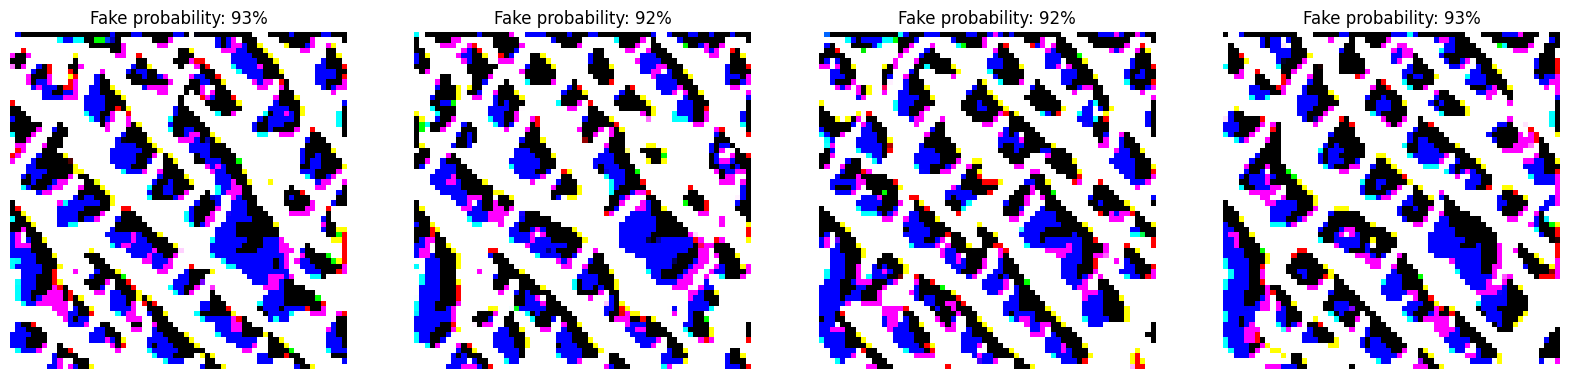

In [28]:
fig, ax = plt.subplots(ncols=n_generated_img, figsize=(20, 20))

for index, image in enumerate(generated_images):
    ax[index].imshow(image)
    ax[index].axis("off")
    ax[index].set_title("Fake probability: {}%".format(int(predictions[index]*100)))

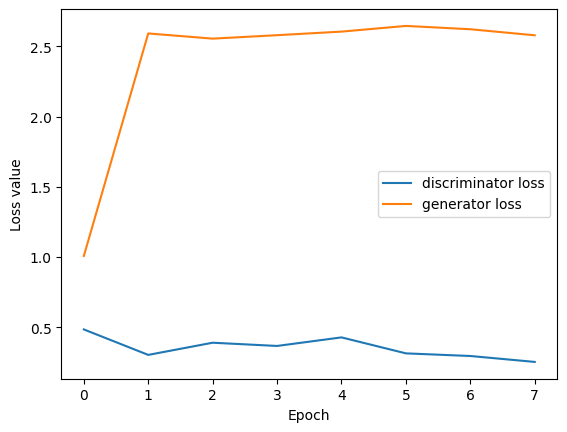

In [21]:
epochs = len(history['dis_loss'])

plt.plot(range(epochs), history['dis_loss'], label="discriminator loss")
plt.plot(range(epochs), history['gen_loss'], label="generator loss")
plt.xlabel("Epoch")
plt.ylabel("Loss value")

plt.legend(loc="center right")

### Transfer Resnet50 fine-tuned for 32h

In [11]:
discriminator_path = "./trained_model/transfer_resnet/30h_dis.h5"
generator_path = "./trained_model/transfer_resnet/30h_gen.h5"

In [89]:
discriminator_path = "./trained_model/transfer_resnet/one_epoch_dis.h5"
generator_path = "./trained_model/transfer_resnet/one_epoch_gen.h5"

In [12]:
gen_resnet = load_model(generator_path, compile=False)
dis_resnet = load_model(discriminator_path, compile=False)

In [13]:
generated_images = gen_resnet.predict(tf.random.uniform((n_generated_img, config.NOISE_VECTOR_SIZE, 1)))
predictions = dis_resnet.predict(generated_images)

1/1 [==============================] - 1s 896ms/step


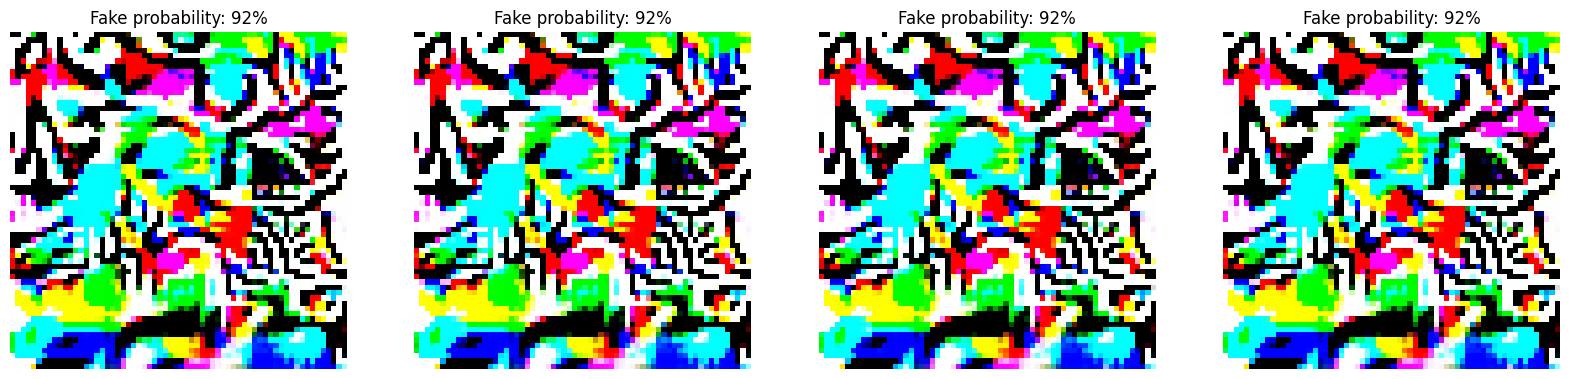

In [14]:
fig, ax = plt.subplots(ncols=n_generated_img, figsize=(20, 20))

for index, image in enumerate(generated_images):
    ax[index].imshow(image)
    ax[index].axis("off")
    ax[index].set_title("Fake probability: {}%".format(int(predictions[index]*100)))

In [29]:
img1 = generated_images[2]
img2 = generated_images[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 63.5, 63.5, -0.5)

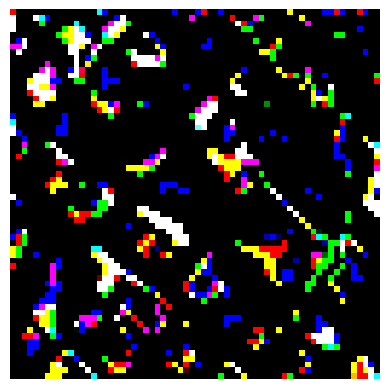

In [30]:
subtraction = img1 - img2
plt.imshow(subtraction)
plt.axis("off")

In [80]:
from keras.applications.resnet import preprocess_input
# from keras.applications.xception import preprocess_input


def load_and_resize(image_filepath):
    img = tf.io.read_file(image_filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)

    img = tf.image.resize(img, size=config.IMAGE_SIZE, method="nearest")

    # applying resnet preprocess
    img = preprocess_input(img)

    return img

In [81]:
data_gen = DataGenerator.DataGenerator(images_dir, map_default_process=False, test_size=0.9)
train_dataset = data_gen.train_dataset.map(load_and_resize, num_parallel_calls=tf.data.AUTOTUNE)

train_batches = train_dataset.cache().shuffle(config.BUFFER_SIZE).batch(n_generated_img)
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Found 5108 images.
510 of them are in train set, and the rest 4598 are in the test set.
Default preprocessing mapped (resizing, loading)


In [82]:
sample_batch = next(iter(train_batches))

In [83]:
real_images_pred = dis.predict(sample_batch)

1/1 [==============================] - 0s 112ms/step


In [84]:
real_images_pred

array([[0.06874703],
       [0.06874622],
       [0.06875608],
       [0.06875936]], dtype=float32)

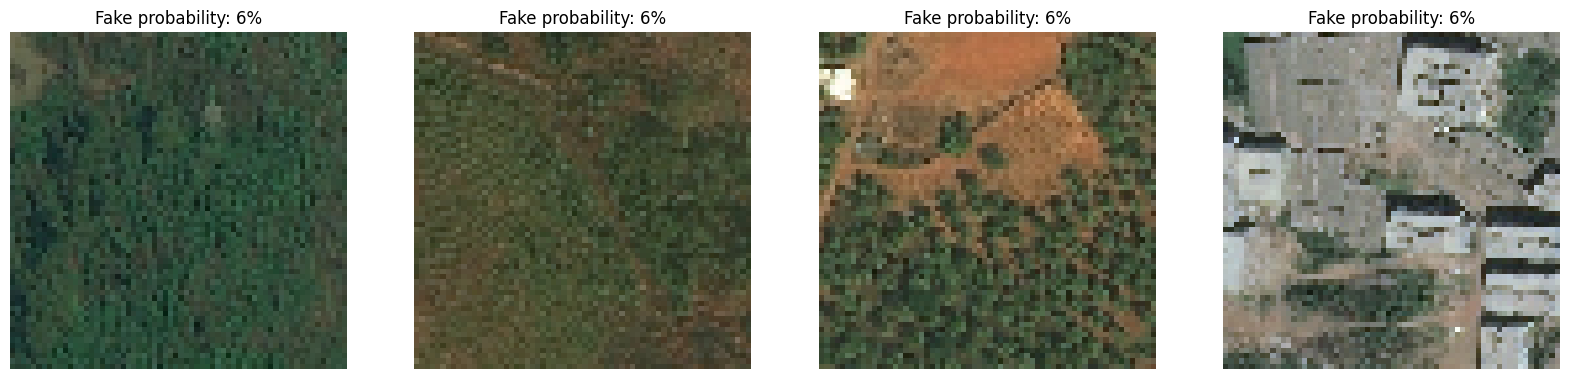

In [67]:
fig, ax = plt.subplots(ncols=n_generated_img, figsize=(20, 20))

for index, image in enumerate(sample_batch):
    ax[index].imshow(image)
    ax[index].axis("off")
    ax[index].set_title("Fake probability: {}%".format(int(real_images_pred[index]*100)))

### Not trained GAN

In [36]:
generator = GAN.build_generator()

In [38]:
not_trained_pred = generator.predict(tf.random.uniform((n_generated_img, config.NOISE_VECTOR_SIZE, 1)))

1/1 [==============================] - 0s 208ms/step


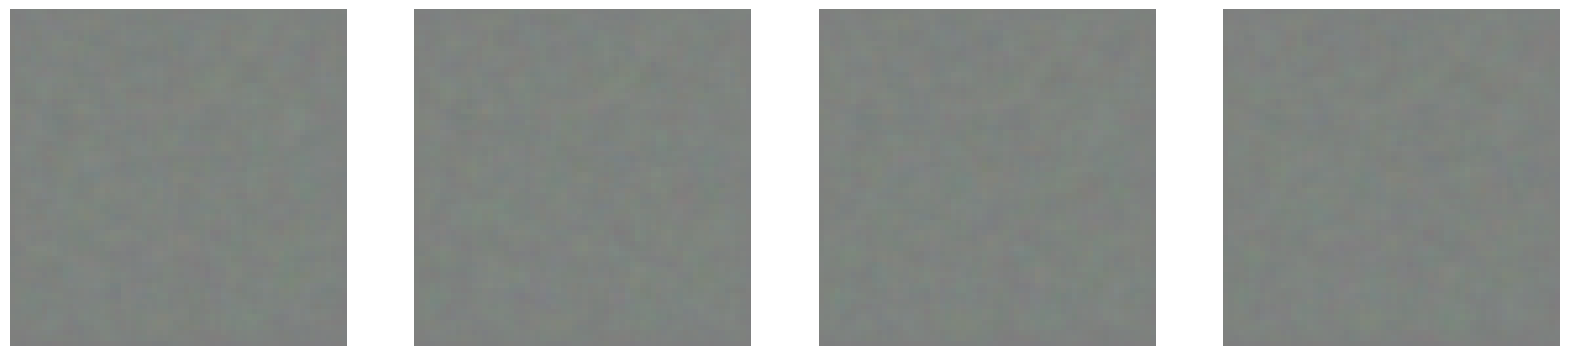

In [40]:
fig, ax = plt.subplots(ncols=n_generated_img, figsize=(20, 20))

for index, image in enumerate(not_trained_pred):
    ax[index].imshow(image)
    ax[index].axis("off")